# Exercise 1
a) Extend the Hough transform demo and plot all the possible lines above a given threshold (relative to the maximum value).

In [2]:
import math
import numpy as np

eps = 1e-15

# img should be a h x w x 1 image after canny edge detector
# the function will return the hough response and samples on the most probable line
def compute_hough_space(img, threshold=0.9, rho_bin = 200, theta_bin = 300):
  h, w = img.shape
  theta_max = 1.0 * math.pi
  theta_min = 0.0

  rho_min = 0.0
  rho_max = math.hypot(h, w)

  hough_space = np.zeros((rho_bin, theta_bin))

  for y in range(h):
    for x in range(w):
      # skip points that are not on the line
      if img[y, x] == 0:
        continue
      else:
        for itheta in range(theta_bin):
          theta = (1.0 * itheta) * (theta_max / theta_bin) # find theta bin
          rho = x * math.cos(theta) + y * math.sin(theta)
          irho = int(rho_bin * rho / rho_max) # find the rho bin
          hough_space[irho, itheta] += 1 # a vote for the given point

  # find the most probable line
  r, t = np.unravel_index(np.argmax(hough_space, axis=None), hough_space.shape)
  r_max = r / rho_bin * rho_max
  t_max = t / theta_bin * theta_max

  x = np.arange(w)
  y = (r_max - x * math.cos(t_max)) / (math.sin(t_max) + eps)
  xs = [x]
  ys = [y]
  hough_max = np.max(hough_space)
  for i in range(rho_bin):
      for j in range(theta_bin):
          val = hough_space[i, j]
          if val == hough_max:
              continue
          if val / hough_max > threshold:
              r, t = np.unravel_index(i * rho_bin + j, hough_space.shape)
              r_max = r / rho_bin * rho_max
              t_max = t / theta_bin * theta_max
              x2 = np.arange(w)
              y2 = (r_max - x2 * math.cos(t_max)) / \
                   (eps if math.sin(t_max) == 0 else math.sin(t_max))
              xs.append(x2)
              ys.append(y2)

  hough_space = np.ceil(255 * (hough_space - hough_space.min())/
                        (hough_space.max() - hough_space.min() +
                         0 if hough_space.max() != hough_space.min() else eps))
  return hough_space.astype(np.uint8), xs, ys

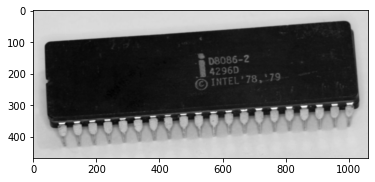

In [4]:
import cv2 as cv
import matplotlib.pyplot as plt


image_rgb = cv.imread("8086.jpg")
image_rgb = cv.GaussianBlur(image_rgb,(5, 5), 0)
img_gray = cv.cvtColor(image_rgb, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

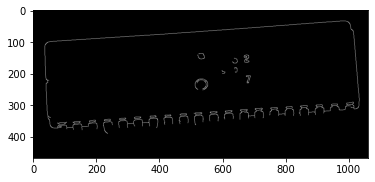

In [26]:
edges = cv.Canny(img_gray, 100, 200)
plt.imshow(edges, cmap='gray')

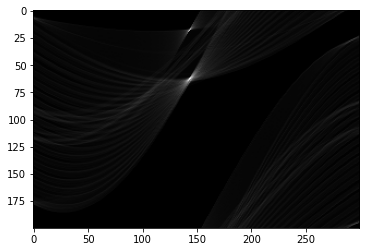

In [57]:
hough_response, x, y = compute_hough_space(edges, threshold=0.94)
plt.imshow(hough_response, cmap='gray')

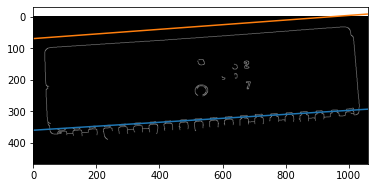

In [54]:
plt.imshow(edges, cmap='gray')
for i, j in zip(x, y):
    plt.plot(i, j)

b) Increase the size of the Hough space response for the given demo (*Intel8086* photo). What happens to the most probable line?

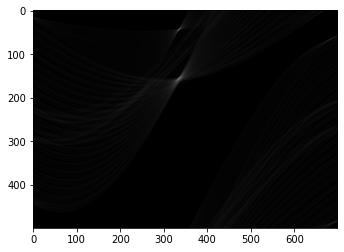

In [58]:
hough_response, x, y = compute_hough_space(edges, threshold=0.94, rho_bin=500, theta_bin=700)
plt.imshow(hough_response, cmap='gray')

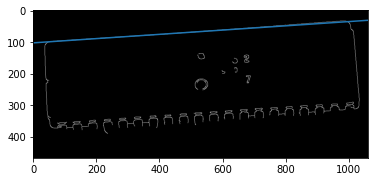

In [59]:
plt.imshow(edges, cmap='gray')
for i, j in zip(x, y):
    plt.plot(i, j)

The line moved from bellow to above when increasing the space of the hough transform.

c) Using the channel-wise image histogram, write a procedure for a better initialization of K-Means.

I've created the histograms for the 3 color channels by hand, I've sorted them and took the best k values.

In [117]:
def visualize_segmentation_map(map):

  h, w = map.shape
  max_colors = int(map.max())
  colors = [np.random.randint(0, 255, size=(3,)).astype(np.uint8) for _ in range(max_colors)]
  output_image = np.zeros((h, w, 3), dtype=np.uint8)

  for i in range(int(h)):
    for j in range(int(w)):
      output_image[i, j, :] = colors[int(map[i, j]) - 1]

  plt.imshow(output_image)


def generate_mu(X, K):
  N, d = X.shape
  mu = np.zeros((d, K))

  # use a min - max initialization to
  # distribute the means across the range
  min_vec = np.zeros(d)
  max_vec = np.zeros(d)

  for i in range(d):
    min_vec[i] = np.min(X[:, i])
    max_vec[i] = np.max(X[:, i])

  for k in range(K):
    mu[:, k] = min_vec.T  + (k - 1) / K * (max_vec - min_vec).T

  print(mu)
  return mu


def generate_mu_better(X, K):
  b = dict()
  for i in X[:, 0]:
      b[i] = b.get(i, 0)
      b[i] += 1
  g = dict()
  for i in X[:, 1]:
      g[i] = g.get(i, 0)
      g[i] += 1
  r = dict()
  for i in X[:, 2]:
      r[i] = r.get(i, 0)
      r[i] += 1
  b = list(({k: v for k, v in sorted(b.items(), key=lambda item: item[1])}.keys()))[::-1]
  g = list(({k: v for k, v in sorted(g.items(), key=lambda item: item[1])}.keys()))[::-1]
  r = list(({k: v for k, v in sorted(r.items(), key=lambda item: item[1])}.keys()))[::-1]

  N, d = X.shape
  mu = np.zeros((d, K))

  for i in range(K):
      mu[0, i] = b[i]
      mu[1, i] = g[i]
      mu[2, i] = r[i]

  print(mu)
  return mu

# img is the Lab image
# K is the number of segments
def KMeans_segmentation(img, K, niter=10):
  h, w, d = img.shape
  pixels = np.zeros((h * w, d))
  k = 0
  for i in range(h):
    for j in range(w):
      pixels[k, :] = img[i, j, :].astype(np.float32)
      k += 1

  map = np.zeros((h, w), dtype=np.uint8)
  means = generate_mu_better(pixels, K)
  # means = generate_mu(pixels, K)

  # phase 1 - assign each pixel to the closest mean
  # phase 2 - update the mean of each cluster
  N = pixels.shape[0]

  it = 0
  while it < niter:
    it += 1
    # phase 1
    for i in range(N):
      diff = means - np.repeat(np.array([pixels[i, :]]).T, K, axis=1)
      dist = np.linalg.norm(diff, axis=0)
      k = np.argmin(dist)
      map[i // w, i % w] = k

    # phase 2
    for k in range(K):
      cluster_idx = np.argwhere(map == k)

      if len(cluster_idx) > 0:
        cluster_idx = [ i * w + j for i, j in cluster_idx]
        cluster_pixels = pixels[cluster_idx]
        means[:, k] = np.mean(cluster_pixels, axis=0)

  return means, map


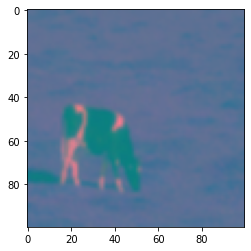

In [69]:
image_cow = cv.imread("cow.jpg")
image_cow = cv.resize(image_cow, (100, 100))
image_cow = cv.GaussianBlur(image_cow,(3, 3), 0)
img_lab = cv.cvtColor(image_cow, cv.COLOR_BGR2LAB)
plt.imshow(img_lab)

[[ 95.  92.  94.  93.  91.]
 [113. 112. 114. 111. 115.]
 [149. 148. 150. 151. 152.]]
[[171.39378238  75.08174807  96.71700969  87.88683075  21.28038898]
 [125.48704663 113.44935733 112.97487893 112.77594519 127.01458671]
 [140.83937824 148.29820051 148.97881356 149.20223294 130.75526742]]


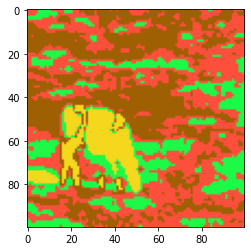

In [118]:
means, map = KMeans_segmentation(img_lab, K=5)
print(means)
visualize_segmentation_map(map)

# Exercise 2
Using an image segmentation technique, determine the best possible initialization for GrabCut, by selecting the smallest possible rectangle enclosing the foreground object.


Using Canny edge detector to retrieve contours and then create the bounding rectangle. Does not give as good results as expected.

(100, 105, 321, 325)


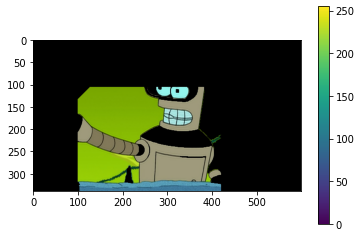

(<matplotlib.image.AxesImage at 0x1a75a6c8d60>,
 None)

In [110]:
path = "bender.png"
imgBGR = cv.imread(path)
img = cv.cvtColor(imgBGR, cv.COLOR_BGR2GRAY)

mask = np.zeros(imgBGR.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
canny = cv.Canny(image=img, threshold1=100, threshold2=200)

cnts = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]

cnt = cnts[9]

x,y,w,h = cv.boundingRect(cnt)

rect = (80,80,450,310)
rect = (x, x + w, y, y + h)
print(rect)
cv.grabCut(imgBGR,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = imgBGR*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()


# Exercise 3
Implement disparity estimation based on minimizing the sum of squared differences between 9x9 image patches in the stereo vision framework. The searching space in the right image is a fixed size image patch of a size given as input (e.g. a 27x27 image patch). The disparity is the horizontal displacement between the position of the center pixel in the left image and the position in the right image that minimizes the SSD.

**Bonus**: Reduce the searching space in the right image using the Fundamental Matrix F.

In [ ]:
def ssd(a, b):
    dif = a.ravel() - b.ravel()
    return np.dot( dif, dif )

def disparity_estimation(patch, image2):
    # both patch and image2 must have 2 dimensions
    n, m = image2.shape
    p = patch.shape[0]
    
    minimum = np.inf
    center = (0, 0)
    for i in range(n - p):
        for j in range(m - p):
            x = ssd(patch, image2[i: i + p, j: j + p])
            if x < minimum:
                minimum = x
                center = (i + p / 2, j + p / 2)
    return center

I've implemented a method that takes a patch and an image and returns the center position in the image which minimizes the ssd.


# Exercise 4
Using the description of the method [here](https://www.sciencedirect.com/science/article/pii/S1077314296900405?via%3Dihub), implement the disparity map estimation method. What type of algorithm is this? How can it be improved?
As a reference, you can download stereo vision images from [here](https://home.cvlab.cs.tsukuba.ac.jp/dataset).
